<a href="https://colab.research.google.com/github/Imartinezcuevas/RL_MC_OL/blob/main/MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo On-Policy

*Description:* Este notebook describe un experimento de aprendizaje por refuerzo utilizando el algoritmo de Monte Carlo On-Policy.
El propósito de este análisis es explicar la implementación del agente y probar con dos entornos (FrozenLake y Taxi) que funciona correctamente.

    Author: Iván Martínez Cuevas y Antonio Orenes Lucas
    Email: ivan.martinezc@um.es y antonio.orenesl@um.es
    Date: 2025/02/12

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



# Introducción a Monte Carlo On-Policy

Monte Carlo On-Polocy es un algoritmo de aprendizaje por refuerzo que aprende el valor de las acciones (función Q) mediante la experiencia obtenida en episodios completos. La característica "On-Policy" significa que la política que utiliza para tomar acciones es la misma política que se está aprendiendo y mejorando.

## Componentes Clave
1. Agente (`Agent`, `TabularAgent`, `MonteCarloAgent`, `MonteCarloOnPolicyAgent`):
  * La clase `Agent` define la estructura general de un agente de RL.
  * `TabularAgent` espcecializa el agente para entornos con espacios de estados y acciones discretos, utilizando una tabla Q para almacenar los valores de acción.
  * `MonteCarloOnPolicyAgent` implementa el algoritmo específico con la actualización de los retornos en orden inverso a las visitas.

2. Política (`Policy`, `EpsilonGreedyPolicy`):
  * La clase `Policy` define la estructura general de una política.
  * `EpsilonGreedyPolicy` basada en la política usada en el ejemplo.
    * Política epsilon-soft: Se define una política donde todas las acciones tienen una probabilidad de ser elegida.
    * Política epsilon-greedy: basada en la política epsilon-soft. De esta forma el agente tiene una pequeña probabilidad de explorar (tomar una acción aleatoria) y una mayor probabilidad de explotar (tomar la acción que considera mejor). Esto permite equilibrar la exploración y la explotación.

3. Entorno (`gym.Env`):
  * El entorno de Gymnasium donde el agente interactua.
  * Los entornos probados son:
    * FrozenLake:  entorno de cuadrícula simple donde el agente debe navegar desde un punto de inicio hasta un punto de destino sin caer en agujeros.
    * Taxi: simula el escenario de un taxi que debe recoger a un pasajero en una de las ubicaciones posibles, llevarlo a su destino y dejarlo allí.

## Preparación del entorno
La preparación consta de las siguientes partes:

* **Instalación de Dependencias**: Se instalan las librerías necesarias para utilizar el entorno gymnasium para la simulación, con el objetivo de crear un ambiente controlado para que el agente pueda interactuar.

* **Importación de Librerías**: Se importan las bibliotecas necesarias como numpy para el manejo de matrices y matplotlib para la visualización de los resultados.

* **Importación de los entornos**: Se cargan dos versiones del entorno "FrozenLake": una de 4x4 y otra de 8x8. Ambas versiones no son resbaladizas, lo que facilita la comprensión de los resultados, dado que el entorno resbaladizo podría dificultar la comprensión inicial del aprendizaje. Además, se carga el entorno "Taxi-V3".

In [1]:
#@title Copiar el repositorio.

!git clone https://github.com/Imartinezcuevas/RL_MC_OL.git
!cd k_brazos_MC_OL/

Cloning into 'RL_MC_OL'...
remote: Enumerating objects: 283, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 283 (delta 1), reused 4 (delta 1), pack-reused 275 (from 1)
Receiving objects: 100% (283/283), 1.74 MiB | 11.12 MiB/s, done.
Resolving deltas: 100% (150/150), done.
/bin/bash: line 1: cd: k_brazos_MC_OL/: No such file or directory


In [2]:
#@title Importamos todas las clases y funciones

%%capture
#@title Instalamos gym
!pip install 'gym[box2d]==0.20.0'

## Instalación de algunos paquetes.
#!apt-get update
## Para usar gymnasium[box2d]
#!apt install swig
#!pip install gymnasium[box2d]

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/RL_MC_OL/src')

# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
from typing import List
import random

from agentes import Agent, TabularAgent, MonteCarloAgent, MonteCarloOffPolicyAgent, MonteCarloOnPolicyAgent
from politicas import Policy, EpsilonGreedyPolicy
from plotting import plot_reward_ratio, plot_episode_lengths

seed_value= 100
random.seed(seed_value)
np.random.seed(seed_value)

In [3]:
#@title Importamos escenarios
name = 'FrozenLake-v1'
env4 = gym.make(name, is_slippery=False, map_name="4x4", render_mode="ansi") # No resbaladizo para entender mejor los resultados.
env8 = gym.make(name, is_slippery=False, map_name="8x8", render_mode="ansi") # No resbaladizo para entender mejor los resultados.
env_taxi = gym.make('Taxi-v3', render_mode="ansi")

## Función de entrenamiento
Se ha modificado el bucle utilizado como referencia para poder usar los agentes desarrollados.

En resumen, la función `train_monte_carlo` simula múltiples episodios de interacción entre el agente y el entorno, actualizando el agente con cada transición y evaluando su rendimiento periódicamente.

In [4]:
# Función de entrenamiento
def train_monte_carlo(agent, env, num_episodes=50000, decay=False, max_step_per_episode=1000):
    evaluation_history = []
    step_display = num_episodes / 10

    for episode in tqdm(range(num_episodes)):
        state, info = env.reset(seed=100)
        agent.start_episode()  # Inicia el episodio para el agente

        done = False
        step = 0
        episode_reward = 0
        while not done and step < max_step_per_episode:
            # Obtiene la acción usando la política
            action = agent.get_action(state)

            # Ejecuta el paso en el entorno
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Actualiza el agente con la transición
            agent.update(state, action, next_state, reward, done, info)

            episode_reward += reward
            state = next_state  # Actualiza el estado
            step += 1

        # Si decay es verdadero, ajusta epsilon
        if decay:
          agent.policy.decay_epsilon()
          #agent.policy.epsilon = min(1.0, 1000.0 / (episode + 1))

        # Guarda las estadísticas del episodio
        agent.end_episode(episode_reward, step)

        # Muestra la evolución cada cierto número de episodios
        if episode % step_display == 0 and episode != 0:
          success_rate, avg_length, avg_reward = evaluate_agent(agent, env, num_episodes=100)
          print(f"\nPorcentaje de éxito: {success_rate}, Longitud media del episodio: {avg_length}, Recompensa media: {avg_reward}")
          print(f"Epsilon actual: {agent.policy.epsilon:.4f}")

    return agent

## Función de evaluación
La función `evaluate_agent` evalúa el rendimiento del agente ejecutando múltiples episodios con una política determinista (epsilon=0) y calcula métricas como la tasa de éxito, longitud promedio del episodio y recompensa promedio.

In [5]:
def evaluate_agent(agent, env, num_episodes=100):
    success_count = 0
    episode_lengths = []
    total_rewards = []

    # Guardamos el valor original de epsilon
    original_epsilon = agent.policy.epsilon

    # Establecemos epsilon a 0 para evaluación determinista
    agent.policy.epsilon = 0.0

    for _ in range(num_episodes):
        state, _ = env.reset(seed=100)
        done = False
        steps = 0
        episode_reward = 0
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            steps += 1
            episode_reward += reward
            state = next_state
            if terminated and reward > 0:
                success_count += 1
        episode_lengths.append(steps)
        total_rewards.append(episode_reward)

    # Restauramos el valor original de epsilon
    agent.policy.epsilon = original_epsilon

    success_rate = success_count / num_episodes
    avg_episode_length = np.mean(episode_lengths)
    avg_reward = np.mean(total_rewards)
    return success_rate, avg_episode_length, avg_reward

## FrozenLake - 4x4

FrozenLake 4x4 es un entorno que simula un lago congelado. Uno de las características clave de este entorno es que las recompensas son dispersas. Esto puede hacer que el agente tarde muchos episodios en recibir una recompensa positiva, lo que dificulta la actualización de la función de valor.

Aún así, al ser un mapa pequeño no representa muchos problemas a la hora de encontrar la política óptima.

 10%|█         | 5129/50000 [00:14<02:37, 284.41it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0
Epsilon actual: 0.3115


 20%|██        | 10161/50000 [00:19<01:05, 606.83it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0
Epsilon actual: 0.2426


 31%|███       | 15324/50000 [00:21<00:14, 2415.56it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.1889


 41%|████      | 20519/50000 [00:23<00:11, 2662.88it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.1471


 51%|█████     | 25299/50000 [00:26<00:18, 1354.29it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.1146


 60%|██████    | 30223/50000 [00:29<00:14, 1404.24it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.0892


 70%|███████   | 35164/50000 [00:33<00:11, 1240.48it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.0695


 80%|████████  | 40182/50000 [00:36<00:06, 1485.93it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.0541


 91%|█████████ | 45292/50000 [00:39<00:03, 1425.70it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.0422


100%|██████████| 50000/50000 [00:41<00:00, 1203.05it/s]


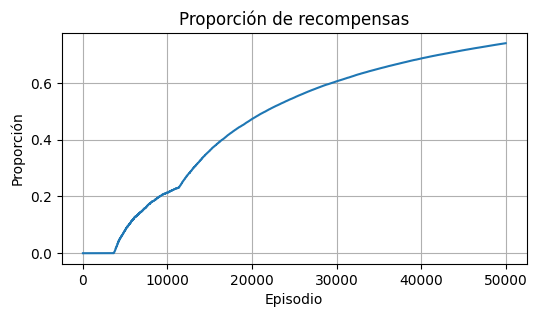

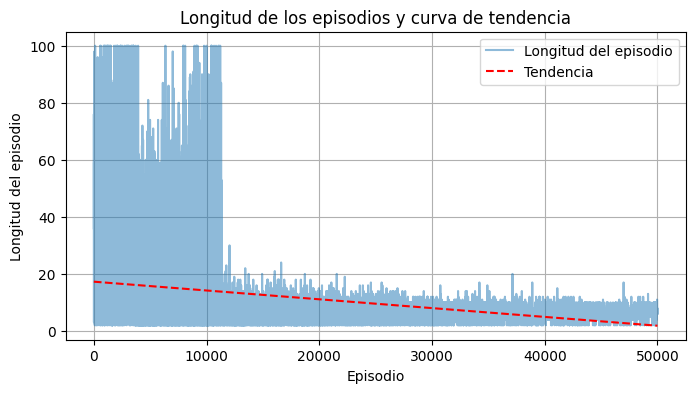

In [6]:
# Crear la política con epsilon 0.4
epsilon_policy = EpsilonGreedyPolicy(env4.action_space, epsilon=0.4, epsilon_decay=0.99995, epsilon_min=0.01)

# Crear el agente usando MonteCarloOnPolicyAgent y la política
agent_env4 = MonteCarloOnPolicyAgent(env4, policy=epsilon_policy, gamma=1.0, first_visit=False)

# Entrenamos al agente
trained_agent_env4 = train_monte_carlo(agent_env4, env4, num_episodes=50000, decay=True)

stats = trained_agent_env4.stats()

# Graficamos los resultados
plot_reward_ratio(stats["reward_ratio"])
plot_episode_lengths(stats["episode_lengths"])

Las gráficas muestran el comportamiento del agente entrenado con Monte Carlo On-Policy en el entorno FrozenLake 4x4.

* **Primera gráfica:**

    Esta gráfica representa la proporción acumulada de recompensas obtenidas a lo largo de los episodios.

    Se puede apreciar que el agente comienza sin conocimientos, por lo que obtiene pocas recompensas. Sin embargo, conforme aprende a navegar en el entorno, la proporción de recompensas aumenta.

    Sobre el episodio 10.000 se puede observar una aceleración en la tasa de éxito, lo que sugiere que el agente ha encontrado mejores estrategias y las aprovecha con mayor frecuencia.

    Sobre el episodio 30.000 se estabiliza el entrenamiento, se sigue aumentando la proporción de recompensas, pero a un ritmo más lento, indicando que el agente ya ha aprendido una política cercana a la óptima.


* **Segunda gráfica:**

    Esta gráfica ilustra la cantidad de pasos necesarios para completar un episodio.

    Al inicio, los episodios pueden ser muy largos, pues el agente explora aleatoriamente. Con el tiempo, el agente aprende estrategias más eficientes. La línea roja muestra la tendencia general, mostrando que el agente encuentra tendencias más óptimas.

In [7]:
# Política Greedy a partir de los valones Q. Se usa para mostrar la solución.
def pi_star_from_Q(env, Q):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset(seed=100) # start in top-left, = 0
    actions = ""
    while not done:
        action = np.argmax(Q[state, :])
        actions += f"{action}, "
        pi_star[state,action] = action
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    return pi_star, actions

Q = trained_agent_env4.get_action_values()
pi, actions = pi_star_from_Q(env4, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env4.render())
print()

Política óptima obtenida
 [[0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]] 
 Acciones 2, 2, 1, 1, 1, 2,  
 Para el siguiente grid
   (Right)
SFFF
FHFH
FFFH
HFFG




Se observa una secuencia de acciones relativamente corta y lógica.

## FrozenLake - 8x8
Con FrozenLake 8x8 aumentamos el espacio de estados. Mucho mayor que el de 4x4, 16 estados contra 64. Esto significa que el agente debe explorar un espacio más amplio para encontrar la ruta óptima.

Además, al ser la ruta más larga, aumenta la duración de los episodios y, por tanto, se ralentiza el aprendizaje, especialmente para los métodos como Monte Carlo que actualiza la función valor al final de cada episodio.

**Problemas y soluciones**
1. Exploración alta (ϵ=1)
  * Problema: al ser un entorno tan grande puede ser que el agente se quede atascado en rutas subóptimas o que nunca llegue al objetivo.
  * Solución: se ha establecido epsilon a 1 para forzar al agente a explorar completamente el entorno al principio. Esto es crucial para descubrir rutas hacia el objetivo.
2. Inicialización optimista
  * Problema: mismo anterior. El agente tarda mucho en asociar valores positivos a las acciones correctas.
  * Solución: La inicialización optimista de los valores Q incentiva al agente a explorar. El agente asume que todas las acciones son muy valiosas lo que lo motiva a probarlas.

 10%|█         | 5139/50000 [00:13<00:55, 806.91it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 16.0, Recompensa media: 1.0
Epsilon actual: 0.0301


 20%|██        | 10226/50000 [00:18<00:36, 1088.41it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 16.0, Recompensa media: 1.0
Epsilon actual: 0.0100


 30%|███       | 15230/50000 [00:22<00:31, 1114.12it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 16.0, Recompensa media: 1.0
Epsilon actual: 0.0100


 40%|████      | 20177/50000 [00:26<00:26, 1137.92it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 16.0, Recompensa media: 1.0
Epsilon actual: 0.0100


 50%|█████     | 25160/50000 [00:30<00:22, 1086.37it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 16.0, Recompensa media: 1.0
Epsilon actual: 0.0100


 60%|██████    | 30132/50000 [00:34<00:18, 1067.14it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 16.0, Recompensa media: 1.0
Epsilon actual: 0.0100


 70%|███████   | 35199/50000 [00:38<00:13, 1118.22it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 16.0, Recompensa media: 1.0
Epsilon actual: 0.0100


 80%|████████  | 40121/50000 [00:42<00:11, 853.30it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 16.0, Recompensa media: 1.0
Epsilon actual: 0.0100


 90%|█████████ | 45145/50000 [00:47<00:04, 1157.75it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 16.0, Recompensa media: 1.0
Epsilon actual: 0.0100


100%|██████████| 50000/50000 [00:50<00:00, 983.50it/s] 


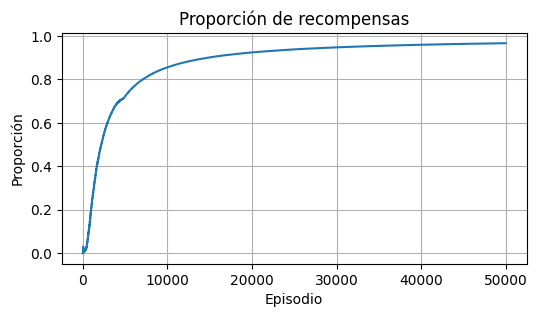

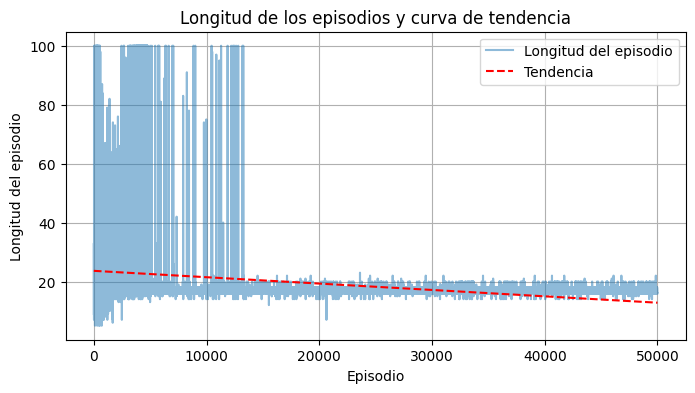

In [8]:
# Crear la política con epsilon 1
epsilon_policy = EpsilonGreedyPolicy(env8.action_space, epsilon=1, epsilon_decay=0.9993, epsilon_min=0.01)

# Crear el agente usando MonteCarloOnPolicyAgent y la política
agent_env8 = MonteCarloOnPolicyAgent(env8, policy=epsilon_policy, optimistic_init=True, init_value=10.0, first_visit=False)

# Entrenamos al agente
trained_agent_env8 = train_monte_carlo(agent_env8, env8, num_episodes=50000, decay=True, max_step_per_episode=200)

stats = trained_agent_env8.stats()

# Graficamos los resultados
plot_reward_ratio(stats["reward_ratio"])
plot_episode_lengths(stats["episode_lengths"])

Las gráficas muestran el comportamiento del agente entrenado con Monte Carlo On-Policy en el entorno FrozenLake 8x8.

* **Primera gráfica:**

    Esta gráfica representa la proporción acumulada de recompensas obtenidas a lo largo de los episodios.

    Tiene un aprendizaje rápido, pues la proporción de recompensas crece de manera rápida en los primeros episodios. Despues del episodio 30.000, el agente ha aprendido una política casi óptima. 

* **Segunda gráfica:**

    Esta gráfica ilustra la cantidad de pasos necesarios para completar un episodio.

    Al inicio, los episodios pueden ser muy largos porque el agente explora sin conocimiento previo. A medida que el agente aprende, los episodios se acortan, lo que indica que está encontrando caminos más eficientes a la meta. La línea discontinua roja muestra una reducción constante en la longitud de los episodios, señal de un aprendizaje efectivo

In [9]:
Q = trained_agent_env8.get_action_values()
pi, actions = pi_star_from_Q(env8, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env8.render())
print()

Política óptima obtenida
 [[0. 1. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 3.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 
 Acciones 1,

## Taxi

El entorno Taxi tiene un espacio de estados discreto pero complejo, definido por la ubicación del taxi, la ubicación del pasajero y el destino del pasajero.

El agente recibe recompensas por acciones correctas y penalizaciones por acciones incorrectas. Esto introduce un elemnto que requeire que el agente evite acciones negativas.

Por todo esto hemos decidido lo siguiente:
* Epsilon alto y decaimiento bajo: asegura una epxloracion extensa al inicio y lo prologamos durante mñas tiempo, para que no se quede atascado en rutas subóptimas.
* Inicialización optimista: incentivamos al agente a explorar activamente, lo que puede ayudar a descubrir rutas y estrategias eficientes.

 10%|█         | 5071/50000 [00:19<01:29, 501.26it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.5458


 20%|██        | 10091/50000 [00:27<00:54, 730.06it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.3310


 30%|███       | 15121/50000 [00:33<00:39, 874.22it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.2008


 40%|████      | 20155/50000 [00:38<00:38, 774.18it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.1218


 50%|█████     | 25165/50000 [00:42<00:25, 990.27it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0739


 60%|██████    | 30201/50000 [00:47<00:18, 1068.05it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0448


 70%|███████   | 35230/50000 [00:51<00:13, 1085.62it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0272


 80%|████████  | 40243/50000 [00:55<00:09, 1069.86it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0165


 90%|█████████ | 45067/50000 [00:59<00:05, 971.14it/s] 


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100


100%|██████████| 50000/50000 [01:03<00:00, 781.26it/s] 


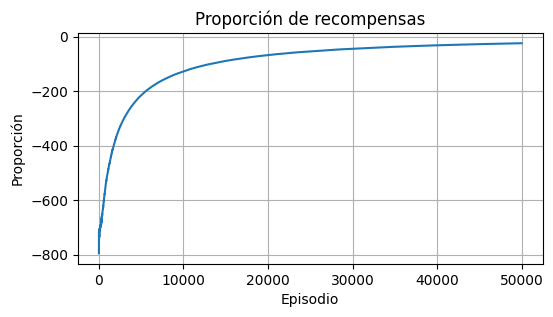

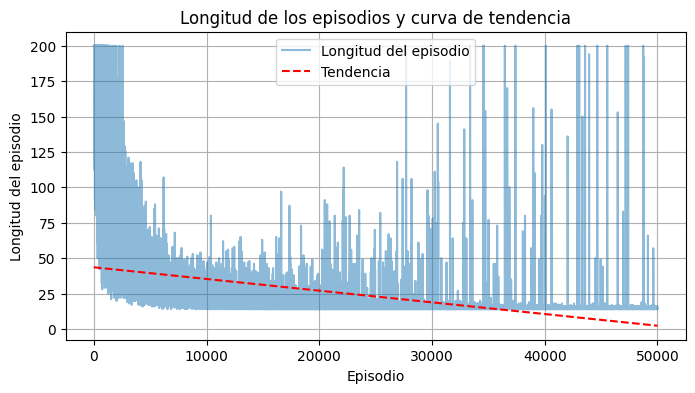

In [10]:
# Crear la política con epsilon 0.4
epsilon_policy = EpsilonGreedyPolicy(env_taxi.action_space, epsilon=0.9, epsilon_decay=0.9999, epsilon_min=0.01)

# Crear el agente usando MonteCarloOnPolicyAgent y la política
agent = MonteCarloOnPolicyAgent(env_taxi, policy=epsilon_policy, gamma=0.95, optimistic_init=True, init_value=5.0, first_visit=False)

# Entrenamos al agente
trained_agent = train_monte_carlo(agent, env_taxi, num_episodes=50000, decay=True)

stats = trained_agent.stats()

# Graficamos los resultados
plot_reward_ratio(stats["reward_ratio"])
plot_episode_lengths(stats["episode_lengths"])

Las gráficas muestran el comportamiento del agente entrenado con Monte Carlo On-Policy en el entorno Taxi-v3.

* **Primera gráfica:**

    Esta gráfica representa la proporción acumulada de recompensas obtenidas a lo largo de los episodios.

    El agente empieza con recompensas muy negativas (~-800 en los primeros episodios), lo cual es esperable en Taxi-v3, ya que al inicio el agente realiza muchas acciones erróneas y recibe penalizaciones.

    Crecimiento exponencial hasta estabilizarse en torno a 0: Esto indica que el agente aprende a minimizar penalizaciones y optimizar la recolección y entrega del pasajero.

    La curva de aprendizaje es más lenta que en FrozenLake, pero estable: La mejora ocurre gradualmente, lo que sugiere que la exploración y la actualización de valores 𝑄 están funcionando correctamente.

* **Segunda gráfica:**

    Esta gráfica ilustra la cantidad de pasos necesarios para completar un episodio.

    Alta variabilidad inicial (~200 pasos por episodio en los primeros intentos): Esto es común en Taxi-v3, ya que al principio el agente explora de forma aleatoria, lo que resulta en trayectorias ineficientes.

    Disminución progresiva de la longitud de los episodios: Con el tiempo, el agente aprende rutas más eficientes, reduciendo los pasos necesarios para completar la tarea.

    Persistencia de picos (~200 pasos en algunos episodios tardíos): Esto indica que en ciertas situaciones el agente aún se encuentra en estados donde no ha aprendido una estrategia clara, posiblemente por la gran cantidad de estados posibles en Taxi-v3.

In [11]:
Q = trained_agent.get_action_values()
pi, actions = pi_star_from_Q(env_taxi, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env_taxi.render())
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 1, 1, 2, 2, 2, 0, 0, 4, 1, 1, 1, 1, 2, 5,  
 Para el siguiente grid
 +---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)




* **El agente sigue un patrón lógico:**

    Primero se mueve hacia el sur (1, 1), lo que sugiere que está acercándose a una ubicación importante (posiblemente un pasajero).

    Luego se mueve hacia el este (2, 2, 2), probablemente para llegar a una posición clave.

    Hace algunas correcciones hacia el norte (0, 0), lo que sugiere que está ajustando su posición antes de recoger al pasajero.

    Ejecuta la acción 4 (Recoger pasajero).

    Luego sigue moviéndose para encontrar la ruta hacia el destino.

    Finalmente, realiza la acción 5 (Dejar pasajero), lo que indica que ha aprendido a completar la tarea correctamente.
    

* **El agente ha aprendido a navegar en Taxi-v3:**

    Al inicio de la simulación, el taxi y el pasajero pueden estar en cualquiera de varias ubicaciones.

    La secuencia de acciones muestra movimientos estructurados y correctos, indicando que el agente sabe cómo recoger y dejar al pasajero.

    La política aprendida es razonable y efectiva.
